# Lab 09 LSTM 

## We will create a simple LSTM class and evaluate on synthetic and real datasets 

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt


## Data generation 

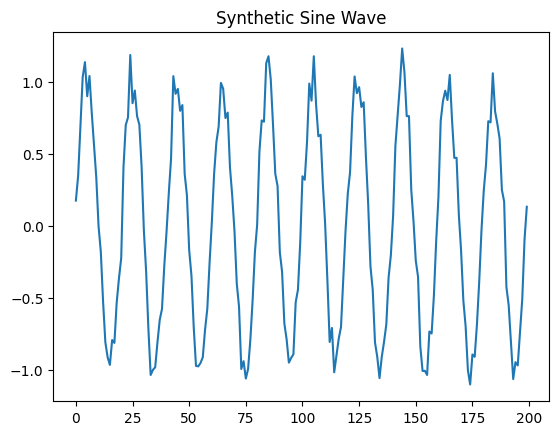

In [2]:
# Make a noisy sine wave
np.random.seed(0)
T = 200
x = np.linspace(0, 20*np.pi, T)
y = np.sin(x) + 0.1*np.random.randn(T)

plt.plot(y)
plt.title("Synthetic Sine Wave")
plt.show()


### Create windows of 50 tiem steps. <br> 
 **We will predict next window** <br>
 

In [6]:
SEQ_LEN = 50

X = []
Y = []

for i in range(len(y) - SEQ_LEN):
    X.append(y[i:i+SEQ_LEN])
    Y.append(y[i+SEQ_LEN])

X = np.array(X).reshape(-1, SEQ_LEN, 1)
Y = np.array(Y).reshape(-1, 1)
print("X shape:", X.shape)
print("Y shape:", Y.shape)

# we will have 150 sample points with 50 time steps each
# Y contains the next value after each sequence

X shape: (150, 50, 1)
Y shape: (150, 1)


In [ ]:
# Train-test split
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
Y_train, Y_test = Y[:split], Y[split:]

X_train_t = torch.tensor(X_train, dtype=torch.float32)
Y_train_t = torch.tensor(Y_train, dtype=torch.float32)
X_test_t  = torch.tensor(X_test, dtype=torch.float32)
Y_test_t  = torch.tensor(Y_test, dtype=torch.float32)


### Simple LSTM network 

In [8]:
class LSTMNet(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc   = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]    # last time step
        out = self.fc(out)
        return out


### Model training 

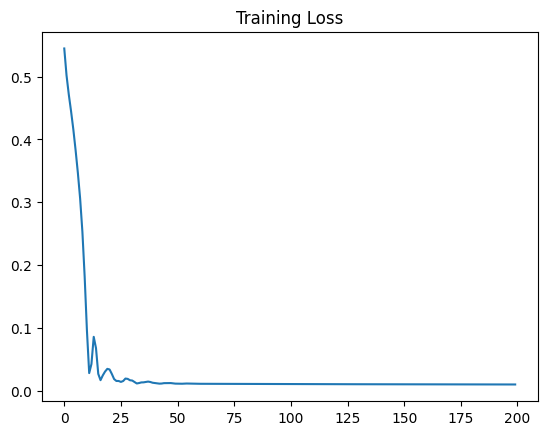

In [9]:
model = LSTMNet()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

epochs = 200
losses = []

for ep in range(epochs):
    model.train()
    pred = model(X_train_t)
    loss = criterion(pred, Y_train_t)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())

plt.plot(losses)
plt.title("Training Loss")
plt.show()


### Evaluation 

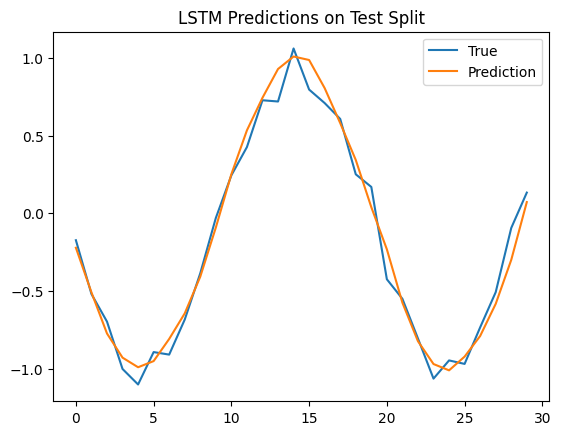

In [10]:
model.eval()
pred_test = model(X_test_t).detach().numpy()

plt.plot(Y_test, label="True")
plt.plot(pred_test, label="Prediction")
plt.legend()
plt.title("LSTM Predictions on Test Split")
plt.show()


# Airline Passeneger Dataset (Kaggle) 

## dataset 
https://www.kaggle.com/code/sunaysawant/air-passengers-time-series-arima


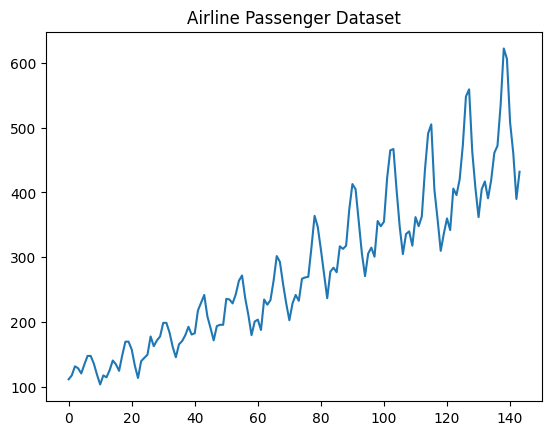

In [11]:
import pandas as pd

# You can replace this with "AirPassengers.csv" from Kaggle
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url)

plt.plot(df["Passengers"])
plt.title("Airline Passenger Dataset")
plt.show()


## Prepare the datatset
we will take one year of the data to predict next month. So our seq lenght would be 12 

In [12]:
data = df["Passengers"].values.astype(float)
data = (data - data.mean()) / data.std()

SEQ_LEN = 12  # use one year to predict next month

X, Y = [], []
for i in range(len(data) - SEQ_LEN):
    X.append(data[i:i+SEQ_LEN])
    Y.append(data[i+SEQ_LEN])

X = np.array(X).reshape(-1, SEQ_LEN, 1)
Y = np.array(Y).reshape(-1, 1)

print("X shape:", X.shape)
print("Y shape:", Y.shape)
# Train-test split

split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
Y_train, Y_test = Y[:split], Y[split:]

X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
Y_train_t = torch.tensor(Y_train, dtype=torch.float32)
Y_test_t = torch.tensor(Y_test, dtype=torch.float32)



X shape: (132, 12, 1)
Y shape: (132, 1)


### Train the model 

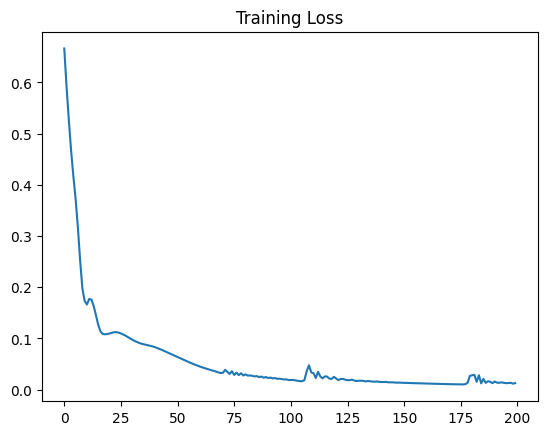

In [13]:
model = LSTMNet()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

epochs = 200
losses = []

for ep in range(epochs):
    model.train()
    pred = model(X_train_t)
    loss = criterion(pred, Y_train_t)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())

plt.plot(losses)
plt.title("Training Loss")
plt.show()


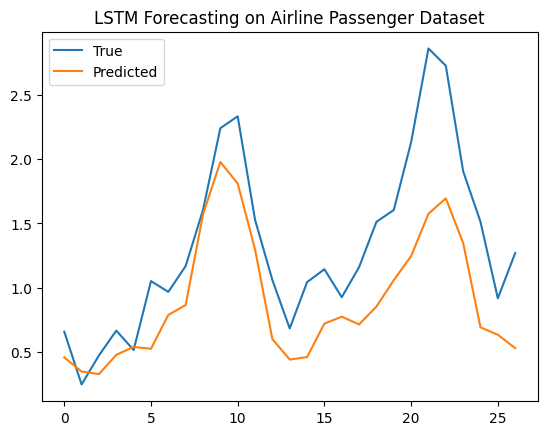

In [14]:
# Evaluate on test set
model.eval()
preds = model(X_test_t).detach().numpy()

plt.plot(Y_test, label="True")
plt.plot(preds, label="Predicted")
plt.legend()
plt.title("LSTM Forecasting on Airline Passenger Dataset")
plt.show()
